# HW1: NYC taxi maturity model

In [1]:
import pandas as pd
import sys
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
# !{sys.executable} -m pip install pyarrow fastparquet 

In [2]:
pd.__version__

'2.2.3'

## Get data

In [3]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [5]:
# Build model to predict ride duration from other features
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df = df[(df.duration >= 1) & (df.duration <= 60)]
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0,19.800000
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,6.600000
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0,17.916667
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0,8.300000
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0,6.100000


<Axes: >

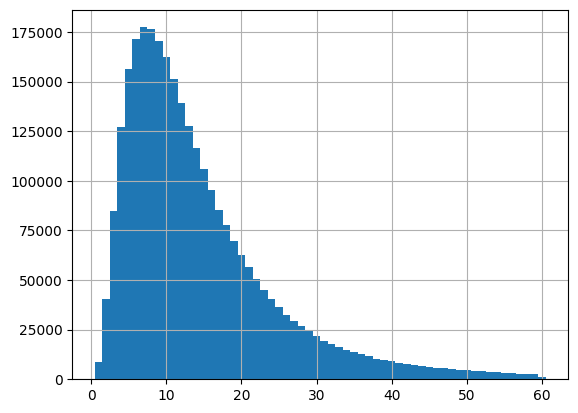

In [6]:
binsize = 1
df['duration'].hist(bins = np.arange(df['duration'].min()-binsize/2, df['duration'].max() + (1.01*binsize/2), binsize))

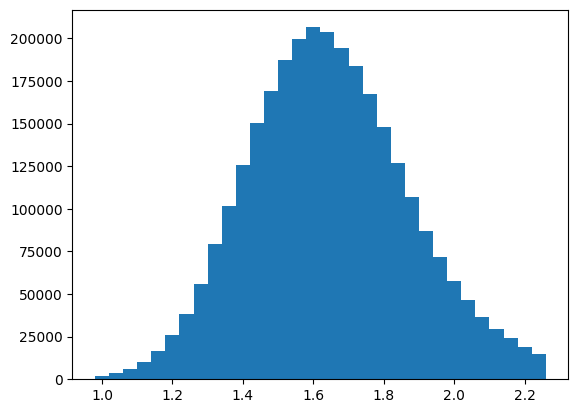

In [7]:
# Just playing around with this. Ultimately it's residuals that we need to be normally distributed 
power = .2
binsize = power/5
plt.hist(np.pow(df.duration, power), bins = np.arange(np.pow(df['duration'].min(), power)-binsize/2, np.pow(df['duration'].max(), power) + (1.01*binsize/2), binsize))
plt.show()

## EDA

In [8]:
# Feature types
df.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
duration                        float64
dtype: object

In [9]:
df['fare_amount'].describe(percentiles=[.01, .02, .05, .95, .98, .99])

count    2.898906e+06
mean     1.756350e+01
std      1.626598e+01
min     -6.500000e+02
1%      -4.400000e+00
2%       4.400000e+00
5%       5.800000e+00
50%      1.280000e+01
95%      5.270000e+01
98%      7.000000e+01
99%      7.000000e+01
max      6.500000e+02
Name: fare_amount, dtype: float64

In [10]:
# it seems that anything that's negative shouldn't be
df[[col for col in df.columns if df.dtypes[col] in ['float64', 'int32']]] = df[[col for col in df.columns if df.dtypes[col] in ['float64', 'int32']]].abs()
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0,19.800000
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0,6.600000
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0,17.916667
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0,8.300000
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0,6.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN,8.616667
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN,14.750000
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN,19.000000
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN,17.850000


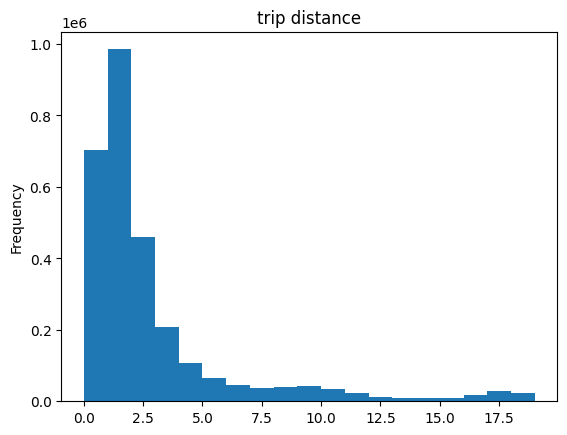

trip distance outlier proportion 0.00804613878476915


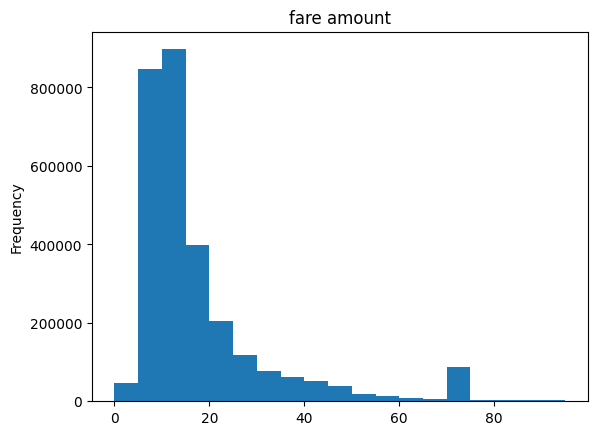

trip fare amount outlier proportion 0.001769978053789947
trip fare amount less than 0 proportion 0.0


In [11]:
# Reasonable to expect that some of these are going to be related to each other e.g. trip distance + fare amount. Let's look at those first
cutoff_tripdist = 20
df['trip_distance'][df['trip_distance'] < cutoff_tripdist].plot.hist(bins = np.arange(0,cutoff_tripdist,1), title = 'trip distance')
plt.show()
print('trip distance outlier proportion', (df['trip_distance'] > cutoff_tripdist).mean())

cutoff_fareamount = 100
df['fare_amount'][df['fare_amount'] < cutoff_fareamount].plot.hist(bins = np.arange(0,cutoff_fareamount,5), title = 'fare amount')
plt.show()
print('trip fare amount outlier proportion', (df['fare_amount'] > cutoff_fareamount).mean())
print('trip fare amount less than 0 proportion', (df['fare_amount'] < 0).mean())

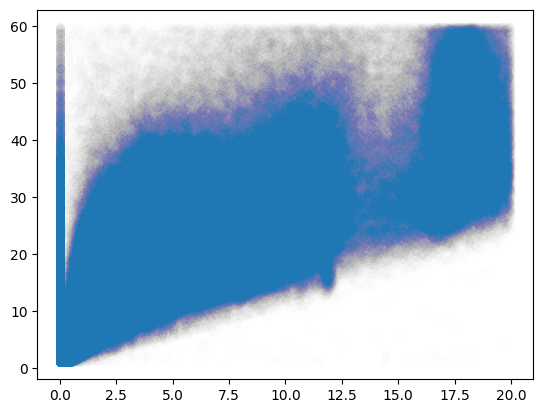

In [12]:
plt.scatter(df['trip_distance'][df['trip_distance'] < cutoff_tripdist], df['duration'][df['trip_distance'] < cutoff_tripdist], alpha = .005)

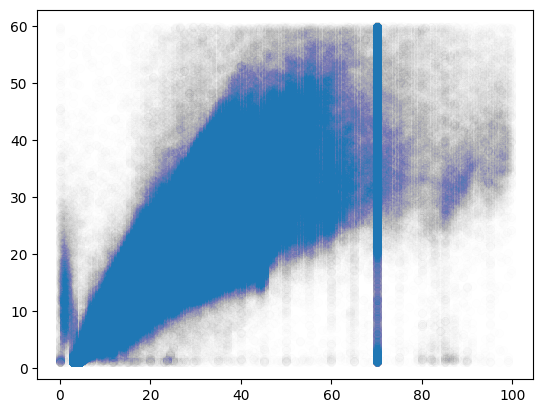

In [13]:
plt.scatter(df['fare_amount'][df['fare_amount'] < cutoff_fareamount], df['duration'][df['fare_amount'] < cutoff_fareamount], alpha = .005)

In [14]:
for i in range(0,100,5):
    print(i, df[df['fare_amount'] == i]['Airport_fee'].mean(), df[df['fare_amount'] != i]['Airport_fee'].mean() )
# Seems like the $70 rides are mostly airport rides

0 0.15078328981723238 0.14011281972866885
5 0.0 0.1401146049276532
10 0.0035463353302270543 0.14714879080707086
15 0.07777777777777778 0.14011633299445597
20 0.01912568306010929 0.1401223224194484
25 0.027559055118110236 0.1401194794165483
30 0.1625 0.14011316486258915
35 0.16826923076923078 0.14011323947131968
40 0.16304347826086957 0.14011296282675906
45 1.0982521186440677 0.1378149722397348
50 0.13522727272727272 0.14011468990175235
55 0.5283018867924528 0.14009193757302923
60 0.20945945945945946 0.14010779278422422
65 0.4103448275862069 0.14008590547318123
70 1.3029801120620652 0.10486560364974866
75 0.30743243243243246 0.14010532833629707
80 0.9082699619771863 0.13996788732516854
85 0.3449519230769231 0.14008342367909188
90 0.3153153153153153 0.1401072544095754
95 0.205078125 0.14011128759706326


In [15]:
df[df['Airport_fee'] > 0]['PULocationID'].value_counts() # 132 = JFK, 138 = LaGuardia, 70 = near LaGuardia

is_airport = defaultdict(int)
is_airport[132] = 1
is_airport[138] = 1
is_airport[70] = 1
df['airport_pickup'] = df['PULocationID'].map(is_airport)

<Axes: xlabel='airport_pickup', ylabel='duration'>

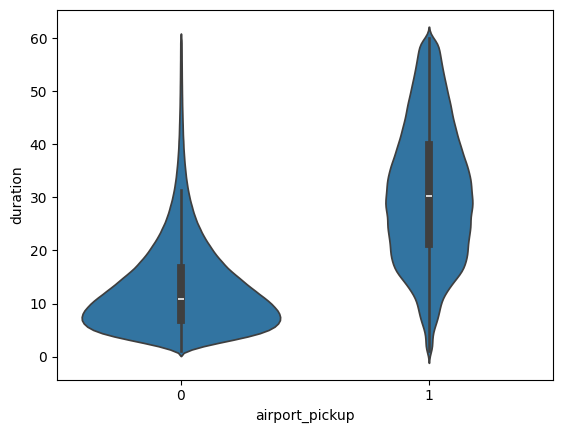

In [16]:
import seaborn as sns
sns.violinplot(data=df, x='airport_pickup', y='duration')

In [17]:
# Cut down the df
limits = {
    'trip_distance': 20,
    'fare_amount': 100,
}

for col in limits:
    df = df[df[col] < limits[col]]

## Basic modelling

In [18]:
X = df[['airport_pickup', 'fare_amount', 'trip_distance']].copy()
y = df['duration'].copy()

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=.9, random_state=1)

In [19]:
# Try a linear model first
lr = sklearn.linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# R2
print(lr.score(X_train, y_train), lr.score(X_test, y_test))

# abs error
print('train error', sklearn.metrics.mean_absolute_error(y_true=y_train, y_pred=lr.predict(X_train)))
print('test error', sklearn.metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred))

# model parameters
print(lr.coef_) # bizarre that there are negative coefficients in this

0.7681360313909136 0.7616009410419001
train error 2.8586584285175833
test error 2.8657397003346468
[-4.59864346  0.84503749 -0.79106202]


In [20]:
# Then try a lasso
lassr = sklearn.linear_model.Lasso()
lassr.fit(X_train, y_train)
y_pred = lassr.predict(X_test)

# R2
print(lassr.score(X_train, y_train), lassr.score(X_test, y_test))

# abs error
print('train error', sklearn.metrics.mean_absolute_error(y_true=y_train, y_pred=lassr.predict(X_train)))
print('test error', sklearn.metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred))

# model parameters
print(lassr.coef_)

0.7480666109206431 0.7434703473341391
train error 3.288055264274232
test error 3.2909874437857027
[-0.          0.62587727 -0.13297796]


In [21]:
# rf = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)

# # abs error
# print('train error', sklearn.metrics.mean_absolute_error(y_true=y_train, y_pred=rf.predict(X_train)))
# print('test error', sklearn.metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred)) # this is better than lr but too big for github codespaces

In [22]:
# print(rf.feature_importances_)
# # R2
# print(rf.score(X_train, y_train), rf.score(X_test, y_test))

In [23]:
# rf.feature_names_in_

## Save model

In [24]:
import pickle

In [27]:
with open('models/lr_model.bin', 'wb') as f_out:
    pickle.dump(lr, f_out)

# with open('models/lr_model.bin')